In [ ]:
# working with colab
# !pip install torchmetrics
# !git clone https://github.com/Nhrot22230/DeepSampler
#  !cd DeepSampler && make init

# import os
# import sys

# # Suponiendo que clonaste el repositorio en /content/DeepSampler
# project_root = os.path.join(os.getcwd(), "DeepSampler")
# if project_root not in sys.path:
#     sys.path.insert(0, project_root)

In [1]:
import os
import sys

project_root = os.getcwd()
while "src" not in os.listdir(project_root):
    project_root = os.path.dirname(project_root)
sys.path.append(project_root)

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import librosa

from src.pipelines.data import musdb_pipeline
from src.pipelines.train import train_pipeline
from src.pipelines.infer import infer_pipeline
from src.pipelines.eval import eval_pipeline
from src.models import DeepSampler
from src.utils.data.dataset import MUSDBDataset
from src.utils.training.loss import MultiSourceLoss

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

2025-02-20 13:10:38.592114: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-20 13:10:38.707445: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740075038.779254 1938608 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740075038.799194 1938608 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-20 13:10:38.904048: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [3]:
# Audio parameters
SR = 44100
NFFT = 1024
HOP = 512
CHUNK_DUR = 2
OVERLAP = 0
BATCH_SIZE = 2

# Model parameters
N_SOURCES = 4
N_LAYERS = 4
N_HEADS = 8
DROPOUT = 0.1
DEPTH = 4

data_path = os.path.join(project_root, "data")
musdb_path = os.path.join(data_path, "musdb18hq")
train_path = os.path.join(data_path, "musdb18hq", "train")
test_path = os.path.join(data_path, "musdb18hq", "test")
output_path = os.path.join(data_path, "processed")
experiments_path = os.path.join(project_root, "experiments")
checkpoint_path = os.path.join(experiments_path, "checkpoints2")
results_path = os.path.join(experiments_path, "results")
log_path = os.path.join(experiments_path, "logs")

train_files = os.listdir(train_path)
train_files.sort()

instruments = ["vocals", "drums", "bass", "other"]
model = DeepSampler()
model.to(device)
criterion = MultiSourceLoss(weights=[1, 1, 1, 1])
calculated_shape = (BATCH_SIZE, N_SOURCES, NFFT // 2 + 1, CHUNK_DUR * SR // HOP + 1)
calculated_shape

(2, 4, 513, 173)

## Training

In [4]:
instruments = ["drums", "bass", "other", "vocals"]
isolated_dataset = {inst: None for inst in instruments}
for i, inst in enumerate(instruments):
    isolated_dataset[inst] = musdb_pipeline(
        musdb_path=os.path.join(musdb_path, "train"),
        isolated=[inst],
        sample_rate=SR,
        n_fft=NFFT,
        hop_length=HOP,
        chunk_duration=CHUNK_DUR,
        overlap=OVERLAP,
        max_chunks=250,
    )

# combine isolated datasets
combined_data = []
for inst in instruments:
    dataset = isolated_dataset[inst]
    combined_data.extend(dataset.data)
    del dataset, isolated_dataset[inst]

combined_dataset = MUSDBDataset(data=combined_data, n_fft=NFFT, hop_length=HOP)
del combined_data

Total chunks:   0%|          | 0/250 [00:00<?, ?chunk/s]

Tracks:   0%|          | 0/100 [00:00<?, ?it/s]

Total chunks:   0%|          | 0/250 [00:00<?, ?chunk/s]

Tracks:   0%|          | 0/100 [00:00<?, ?it/s]

Total chunks:   0%|          | 0/250 [00:00<?, ?chunk/s]

Tracks:   0%|          | 0/100 [00:00<?, ?it/s]

Total chunks:   0%|          | 0/250 [00:00<?, ?chunk/s]

Tracks:   0%|          | 0/100 [00:00<?, ?it/s]

In [5]:
train_dataset = musdb_pipeline(
    musdb_path=train_path,
    sample_rate=SR,
    n_fft=NFFT,
    hop_length=HOP,
    chunk_duration=CHUNK_DUR,
    overlap=OVERLAP,
    save_dir=output_path,
    max_chunks=4000,
)

Total chunks:   0%|          | 0/4000 [00:00<?, ?chunk/s]

Tracks:   0%|          | 0/100 [00:00<?, ?it/s]

In [6]:
isolated_dataloader = torch.utils.data.DataLoader(
    combined_dataset,
    batch_size=4,
    shuffle=True,
)

In [7]:
history = train_pipeline(
    model=model,
    criterion=criterion,
    optimizer=torch.optim.Adam(model.parameters(), lr=3e-3),
    dataloader=isolated_dataloader,
    epochs=5,
    device=device,
)
del isolated_dataloader, history

  0%|          | 0/5 [00:00<?, ?epoch/s]

  0%|          | 0/250 [00:00<?, ?batch/s]

  0%|          | 0/250 [00:00<?, ?batch/s]

  0%|          | 0/250 [00:00<?, ?batch/s]

  0%|          | 0/250 [00:00<?, ?batch/s]

  0%|          | 0/250 [00:00<?, ?batch/s]


Training completed in 95.8 seconds


In [8]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
)

In [9]:
try:
    history = train_pipeline(
        model=model,
        criterion=criterion,
        optimizer=torch.optim.AdamW(model.parameters()),
        dataloader=train_loader,
        epochs=50,
        checkpoint_dir=checkpoint_path,
        checkpoint_every=5,
        device=device,
    )
except RuntimeError as error:
    if "out of memory" in str(error):
        print("Error: No se pudo asignar memoria en la GPU. Liberando memoria...")
        torch.cuda.empty_cache()
    else:
        print("Se produjo un error:", error)
    raise

  0%|          | 0/50 [00:00<?, ?epoch/s]

  0%|          | 0/500 [00:00<?, ?batch/s]

  0%|          | 0/500 [00:00<?, ?batch/s]

  0%|          | 0/500 [00:00<?, ?batch/s]

  0%|          | 0/500 [00:00<?, ?batch/s]

  0%|          | 0/500 [00:00<?, ?batch/s]

Saved checkpoint to /home/nhrot/Programming/Python/DeepLearning/DeepSampler/experiments/checkpoints2/checkpoint_epoch005.pth


  0%|          | 0/500 [00:00<?, ?batch/s]

  0%|          | 0/500 [00:00<?, ?batch/s]

  0%|          | 0/500 [00:00<?, ?batch/s]

  0%|          | 0/500 [00:00<?, ?batch/s]

  0%|          | 0/500 [00:00<?, ?batch/s]

Saved checkpoint to /home/nhrot/Programming/Python/DeepLearning/DeepSampler/experiments/checkpoints2/checkpoint_epoch010.pth


  0%|          | 0/500 [00:00<?, ?batch/s]

  0%|          | 0/500 [00:00<?, ?batch/s]

  0%|          | 0/500 [00:00<?, ?batch/s]

  0%|          | 0/500 [00:00<?, ?batch/s]

  0%|          | 0/500 [00:00<?, ?batch/s]

Saved checkpoint to /home/nhrot/Programming/Python/DeepLearning/DeepSampler/experiments/checkpoints2/checkpoint_epoch015.pth


  0%|          | 0/500 [00:00<?, ?batch/s]

  0%|          | 0/500 [00:00<?, ?batch/s]

  0%|          | 0/500 [00:00<?, ?batch/s]

  0%|          | 0/500 [00:00<?, ?batch/s]

  0%|          | 0/500 [00:00<?, ?batch/s]

Saved checkpoint to /home/nhrot/Programming/Python/DeepLearning/DeepSampler/experiments/checkpoints2/checkpoint_epoch020.pth


  0%|          | 0/500 [00:00<?, ?batch/s]

  0%|          | 0/500 [00:00<?, ?batch/s]

  0%|          | 0/500 [00:00<?, ?batch/s]

  0%|          | 0/500 [00:00<?, ?batch/s]

  0%|          | 0/500 [00:00<?, ?batch/s]

Saved checkpoint to /home/nhrot/Programming/Python/DeepLearning/DeepSampler/experiments/checkpoints2/checkpoint_epoch025.pth


  0%|          | 0/500 [00:00<?, ?batch/s]

  0%|          | 0/500 [00:00<?, ?batch/s]

  0%|          | 0/500 [00:00<?, ?batch/s]

  0%|          | 0/500 [00:00<?, ?batch/s]

  0%|          | 0/500 [00:00<?, ?batch/s]

Saved checkpoint to /home/nhrot/Programming/Python/DeepLearning/DeepSampler/experiments/checkpoints2/checkpoint_epoch030.pth


  0%|          | 0/500 [00:00<?, ?batch/s]

  0%|          | 0/500 [00:00<?, ?batch/s]

  0%|          | 0/500 [00:00<?, ?batch/s]

  0%|          | 0/500 [00:00<?, ?batch/s]

  0%|          | 0/500 [00:00<?, ?batch/s]

Saved checkpoint to /home/nhrot/Programming/Python/DeepLearning/DeepSampler/experiments/checkpoints2/checkpoint_epoch035.pth


  0%|          | 0/500 [00:00<?, ?batch/s]

  0%|          | 0/500 [00:00<?, ?batch/s]

  0%|          | 0/500 [00:00<?, ?batch/s]

  0%|          | 0/500 [00:00<?, ?batch/s]

  0%|          | 0/500 [00:00<?, ?batch/s]

Saved checkpoint to /home/nhrot/Programming/Python/DeepLearning/DeepSampler/experiments/checkpoints2/checkpoint_epoch040.pth


  0%|          | 0/500 [00:00<?, ?batch/s]

  0%|          | 0/500 [00:00<?, ?batch/s]

  0%|          | 0/500 [00:00<?, ?batch/s]

  0%|          | 0/500 [00:00<?, ?batch/s]

  0%|          | 0/500 [00:00<?, ?batch/s]

Saved checkpoint to /home/nhrot/Programming/Python/DeepLearning/DeepSampler/experiments/checkpoints2/checkpoint_epoch045.pth


  0%|          | 0/500 [00:00<?, ?batch/s]

  0%|          | 0/500 [00:00<?, ?batch/s]

  0%|          | 0/500 [00:00<?, ?batch/s]

  0%|          | 0/500 [00:00<?, ?batch/s]

  0%|          | 0/500 [00:00<?, ?batch/s]

Saved checkpoint to /home/nhrot/Programming/Python/DeepLearning/DeepSampler/experiments/checkpoints2/checkpoint_epoch050.pth

Training completed in 4602.0 seconds


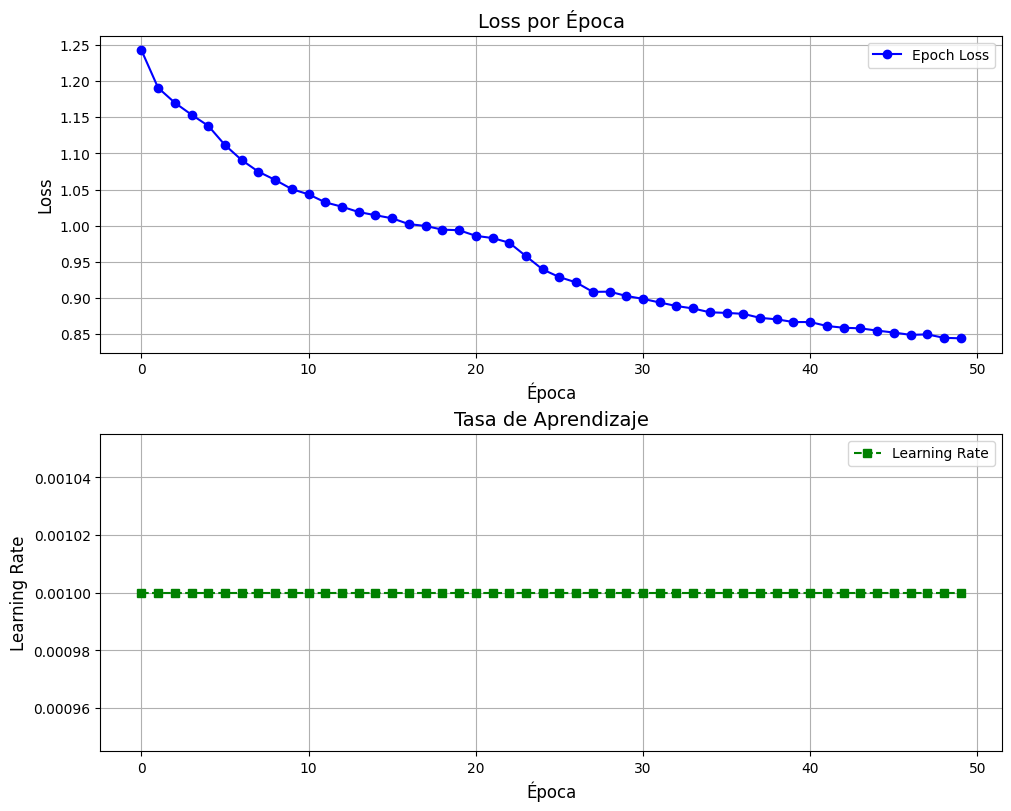

In [10]:
# Supongamos que 'history' es un diccionario con las llaves:
# "epoch_loss", "learning_rate", "batch_losses"
# Por ejemplo:
# history = {
#     "epoch_loss": [0.9, 0.8, 0.7, ...],
#     "learning_rate": [0.001, 0.001, 0.0009, ...],
#     "batch_losses": [[1.0, 0.95, ...], [0.9, 0.85, ...], ...]
# }

fig, axs = plt.subplots(2, 1, figsize=(10, 8), constrained_layout=True)

# Plot para "Epoch Loss"
axs[0].plot(history["loss"], marker="o", color="blue", label="Epoch Loss")
axs[0].set_title("Loss por Época", fontsize=14)
axs[0].set_xlabel("Época", fontsize=12)
axs[0].set_ylabel("Loss", fontsize=12)
axs[0].legend()
axs[0].grid(True)

# Plot para "Learning Rate"
axs[1].plot(
    history["learning_rate"],
    marker="s",
    linestyle="--",
    color="green",
    label="Learning Rate",
)
axs[1].set_title("Tasa de Aprendizaje", fontsize=14)
axs[1].set_xlabel("Época", fontsize=12)
axs[1].set_ylabel("Learning Rate", fontsize=12)
axs[1].legend()
axs[1].grid(True)
plt.show()

## Testing

In [4]:
epoch = 50
model.load_state_dict(
    torch.load(os.path.join(checkpoint_path, f"checkpoint_epoch{epoch:03d}.pth"))
)

<All keys matched successfully>

In [12]:
random_folder = np.random.choice(os.listdir(test_path))
audio_mixture = os.path.join(test_path, random_folder, "mixture.wav")

extracted_sources = infer_pipeline(
    model=model,
    mixture=audio_mixture,
    sample_rate=SR,
    chunk_seconds=CHUNK_DUR,
    overlap=OVERLAP,
    n_fft=NFFT,
    hop_length=HOP,
    device=device,
)

In [13]:
fig, axs = plt.subplots(len(instruments), 2, figsize=(20, 16), constrained_layout=True)

for i, inst in enumerate(instruments):
    # Load the original waveform from file.
    orig_file_path = os.path.join(test_path, random_folder, f"{inst}.wav")
    wav, _ = librosa.load(orig_file_path, sr=SR)

    # Plot the original waveform.
    axs[i, 0].plot(wav, color="tab:blue")
    axs[i, 0].set_title(f"{inst.capitalize()} (Original)", fontsize=16)
    axs[i, 0].set_xlabel("Samples", fontsize=14)
    axs[i, 0].set_ylabel("Amplitude", fontsize=14)
    axs[i, 0].grid(True)

    # Get the extracted waveform.
    pred = extracted_sources[inst]
    # If waveform has more than one channel, use the first channel for plotting.
    if pred.ndim > 1:
        pred = pred[0]
    pred_np = pred.cpu().numpy()

    # Plot the extracted waveform.
    axs[i, 1].plot(pred_np, color="tab:orange")
    axs[i, 1].set_title(f"{inst.capitalize()} (Extracted)", fontsize=16)
    axs[i, 1].set_xlabel("Samples", fontsize=14)
    axs[i, 1].set_ylabel("Amplitude", fontsize=14)
    axs[i, 1].grid(True)

    # Free memory for this loop iteration.
    del wav, pred, pred_np

# Save the complete figure as one large PNG file in RESULTS_PATH.
output_file = os.path.join(results_path, "dino_sampler2", "combined_results.png")
plt.savefig(output_file, bbox_inches="tight", dpi=300)
plt.close(fig)

In [14]:
import torchaudio

for inst in instruments:
    # Save waveform
    file_path = os.path.join(results_path, "dino_sampler", f"{inst}.wav")
    print(f"Saving {inst} to {file_path}")

    waveform = extracted_sources[inst]
    # Ensure waveform is 2D: if it's 1D, add a channel dimension.
    if waveform.ndim == 1:
        waveform = waveform.unsqueeze(0)
    # Convert waveform to float32, which is supported by torchaudio.
    waveform = waveform.to(torch.float32)
    torchaudio.save(file_path, waveform.cpu(), SR)

    # Save spectrogram image
    file_path = os.path.join(results_path, "dino_sampler", f"{inst}.png")
    plt.figure(figsize=(30, 10))
    # Use the first channel if there are multiple channels.
    signal_to_plot = waveform[0].cpu().numpy()
    plt.specgram(signal_to_plot, NFFT=NFFT, Fs=SR, noverlap=OVERLAP)
    plt.axis("off")
    plt.savefig(file_path, bbox_inches="tight")
    plt.close()

Saving drums to /home/nhrot/Programming/Python/DeepLearning/DeepSampler/experiments/results/dino_sampler/drums.wav


/home/nhrot/.pyenv/versions/3.10.16/envs/ia_ml/lib/python3.10/site-packages/matplotlib/axes/_axes.py:8233: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


Saving bass to /home/nhrot/Programming/Python/DeepLearning/DeepSampler/experiments/results/dino_sampler/bass.wav
Saving other to /home/nhrot/Programming/Python/DeepLearning/DeepSampler/experiments/results/dino_sampler/other.wav
Saving vocals to /home/nhrot/Programming/Python/DeepLearning/DeepSampler/experiments/results/dino_sampler/vocals.wav


In [5]:
eval_results = eval_pipeline(
    model=model,
    dataset_path=test_path,
    sample_rate=SR,
    chunk_seconds=CHUNK_DUR,
    overlap=OVERLAP,
    n_fft=NFFT,
    hop_length=HOP,
    device=device,
)

Evaluating: 100%|██████████| 50/50 [03:41<00:00,  4.43s/it]


In [6]:
eval_results

({'vocals': -52.421106796264645,
  'drums': -51.57696266174317,
  'bass': -47.93666145324707,
  'other': -57.16883140563965},
 {'vocals': [-57.67748260498047,
   -66.74159240722656,
   -85.67454528808594,
   -58.46195602416992,
   -54.603538513183594,
   -47.926578521728516,
   -44.64633560180664,
   -47.07961654663086,
   -41.0163688659668,
   -42.90525436401367,
   -45.040992736816406,
   -58.06903076171875,
   -94.92652130126953,
   -37.28619384765625,
   -39.882999420166016,
   -44.318485260009766,
   -64.55949401855469,
   -63.858917236328125,
   -49.87232208251953,
   -51.941246032714844,
   -53.1357536315918,
   -67.133544921875,
   -42.82447814941406,
   -46.942283630371094,
   -53.17963409423828,
   -54.88227844238281,
   -39.664573669433594,
   -59.1416015625,
   -48.56093978881836,
   -45.66940689086914,
   -61.5842399597168,
   -42.89604568481445,
   -55.78525924682617,
   -53.2874755859375,
   -43.230648040771484,
   -40.263065338134766,
   -41.99641418457031,
   -43.57160